# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete SSM.

In [1]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `~/biaslab/repos/EpistemicMessagePassing`


In [2]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
using Random
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664


# Generative Model

In [3]:
fg = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

@RV x_0 ~ Categorical(placeholder(:D_s, dims=(8,)))

x_k_min = x_0
for k=1:2
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k])
    placeholder(u[k], :u, index=k, dims=(8,8))
    @RV y[k] ~ DiscreteObservation{Generalized}(x[k], 
                   placeholder(:A, dims=(16,8), var_id=:A_*k),
                   placeholder(:C, dims=(16,), var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k] # For next slice
end
;

# Algorithm

In [4]:
q = PosteriorFactorization(y, [x_0; x], ids=[:Y, :X])
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
initX() = Array{Message}(undef, 9) # Predefine
eval(Meta.parse(code)) # Overwrites initX for Generalized constraint
;

In [5]:
 println(code)

begin

function stepY!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBDiscreteObservationGeneralizedY(marginals[:y_2], marginals[:x_2], Distribution(MatrixVariate, PointMass, m=data[:A]), Distribution(Multivariate, PointMass, m=data[:C]))
messages[2] = ruleVBDiscreteObservationGeneralizedY(marginals[:y_1], marginals[:x_1], Distribution(MatrixVariate, PointMass, m=data[:A]), Distribution(Multivariate, PointMass, m=data[:C]))

marginals[:y_1] = messages[2].dist
marginals[:y_2] = messages[1].dist

return marginals

end

function initX()

messages = Array{Message}(undef, 10)

messages[5] = Message(vague(Categorical, (8,)))
messages[8] = Message(vague(Categorical, (8,)))

return messages

end

function stepX!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 10))

messages[1] = ruleVBDiscreteObservationGeneralizedS(marginals[:y_1], messages[8], marginals[:x_1], Distribution(MatrixVariate, PointMa

## Action-Perception Loop

In [6]:
using Random

In [7]:
α = 0.9; c = 2.0 # Reward probability and utility
S = 100 # Number of trials
#Random.seed! = 1234 # Randomizer seed
n_its = 2

include("helpers.jl")
include("environment.jl")
include("agent.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

pol = (4,2)

data = Dict(:u   => [B[pol[1]], B[pol[2]]],
            :A   => A,
            :C   => C,
            :D_s => D_0)

marginals = Dict{Symbol, ProbabilityDistribution}(
    :x_0 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :x_1 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)),
    :x_2 => ProbabilityDistribution(Univariate, Categorical, p=asym(8)))

# Define unobserved marginals
marginals[:y_1] = Distribution(Univariate, Categorical, p=asym(16))
marginals[:y_2] = Distribution(Univariate, Categorical, p=asym(16))

messages = initX()
    

10-element Vector{Message}:
 #undef
 #undef
 #undef
 #undef
    Message: Cat(p=[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12])

 #undef
 #undef
    Message: Cat(p=[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12])

 #undef
 #undef

In [8]:
messages

10-element Vector{Message}:
 #undef
 #undef
 #undef
 #undef
    Message: Cat(p=[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12])

 #undef
 #undef
    Message: Cat(p=[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12])

 #undef
 #undef

In [9]:
marginals[:x_1]

Cat(p=[0.12, 0.13, 0.12, 0.13, 0.12, 0.13, 0.12, 0.13])


In [10]:
Gis = zeros(n_its)


stepX!(data, marginals, messages)
stepY!(data, marginals)
freeEnergy(data, marginals)/log(2)

I am s: [0.12495467054373983, 0.1250391498095245, 0.12498303608121678, 0.125020440663928, 0.12495084030691886, 0.12503471572404107, 0.12498898937670185, 0.125028157493929]
I am d: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
I am logC: [-3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836, -3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836, -3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836, -3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836]


I am s: [0.12504255892118632, 0.1250385202617946, 0.12495147331513475, 0.12497140322074698, 0.12498560589413055, 0.1250287813804603, 0.12498240849744119, 0.12499924850910524]
I am d: [1.7437724210137946e-11, 1.7437724210137946e-11, 0.49999999998056205, 0.49999999998056205, 9.999999999930004e-13, 9.999999999930004e-13, 9.999999999930004e-13, 9.999999999930004e-13]
I am logC: [-3.6401503832058357, -3.640150383205835

8.461620404516369

In [11]:
marginals[:x_1]

Cat(p=[1.18e-11, 1.18e-11, 1.18e-11, 1.18e-11, 1.18e-11, 1.18e-11, 0.89, 0.11])


In [12]:
messages

10-element Vector{Message}:
 Message: Cat(p=[0.09, 0.09, 0.26, 0.03, 0.03, 0.26, 0.12, 0.12])

 Message: Cat(p=[0.50, 0.50, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12])

 Message: Cat(p=[3.00e-12, 3.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12, 0.50, 0.50])

 Message: Cat(p=[8.22e-12, 8.22e-12, 8.22e-12, 8.22e-12, 8.22e-12, 8.22e-12, 0.50, 0.50])

 Message: Cat(p=[1.74e-11, 1.74e-11, 0.50, 0.50, 1.00e-12, 1.00e-12, 1.00e-12, 1.00e-12])

 Message: Cat(p=[0.22, 0.22, 0.22, 0.03, 0.02, 0.16, 0.07, 0.07])

 Message: Cat(p=[0.16, 0.02, 0.16, 0.16, 0.16, 0.16, 0.16, 0.02])

 Message: Cat(p=[1.10e-11, 1.10e-11, 1.10e-11, 1.10e-11, 1.10e-11, 1.10e-11, 0.89, 0.11])

 Message: Cat(p=[0.11, 0.01, 0.31, 0.04, 0.04, 0.31, 0.15, 0.02])

 Message: Cat(p=[0.26, 0.03, 0.18, 0.02, 0.18, 0.02, 0.26, 0.03])


In [13]:
C

16-element Vector{Float64}:
 0.02624839635087663
 0.02624839635087663
 0.19395087314359397
 0.0035523341546527592
 0.02624839635087663
 0.02624839635087663
 0.19395087314359397
 0.0035523341546527592
 0.02624839635087663
 0.02624839635087663
 0.19395087314359397
 0.0035523341546527592
 0.02624839635087663
 0.02624839635087663
 0.19395087314359397
 0.0035523341546527592

In [14]:
        
Gis = zeros(n_its)
for i=1:n_its
    stepX!(data, marginals, messages)
    stepY!(data, marginals)
    Gis[i] = freeEnergy(data, marginals)/log(2)
end
;

I am s: [1.1765784868979485e-11, 1.1765784868979485e-11, 1.1765784868979485e-11, 1.1765784868979485e-11, 1.1765784868979485e-11, 1.1765784868979485e-11, 0.8856931432751671, 0.11430685665423802]
I am d: [1.095290923503698e-11, 1.095290923503698e-11, 1.095290923503698e-11, 1.095290923503698e-11, 1.095290923503698e-11, 1.095290923503698e-11, 0.8856931432794869, 0.11430685665479554]
I am logC: [-3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836, -3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836, -3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836, -3.6401503832058357, -3.6401503832058357, -1.6401503832058357, -5.640150383205836]


I am s: [3.0310728425801e-11, 3.0310728425801e-11, 0.8856931432585293, 0.11430685664857741, 8.067904642006173e-12, 8.067904642006173e-12, 8.067904642006173e-12, 8.067904642006173e-12]
I am d: [2.5477231115396225e-11, 2.5477231115396225e-11, 0.2643006275899523, 0.735699372

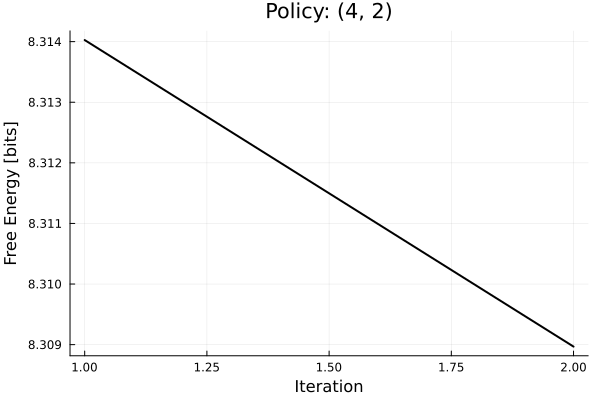

In [15]:
plot(1:n_its, Gis, color=:black, linewidth=2, xlabel="Iteration", ylabel="Free Energy [bits]", label=false, title="Policy: $pol")

#savefig("figures/policy.png")

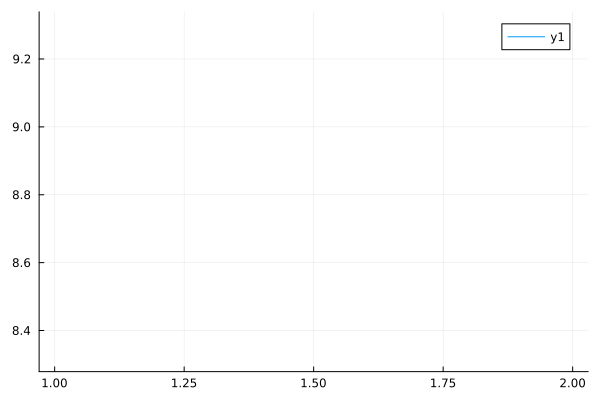

In [16]:
plot(Gis[2:end])